# ELECTRA EN Model

### This notebook contains the implementation of the ELECTRA model pre-trained on the english language set coming from `Datasets/ELECTRA/train_en.csv`

### The following steps are taken to establish the model
- **Data exploration and visualization**
- **Model definition**
- **Optimizer algorithm selection**
- **Loss function selection**
- **Training loop**
- **Model saving**

In [2]:
!pip install -q keras-nlp --upgrade

In [4]:
import matplotlib.pyplot as plt
import pandas
import numpy
import keras_nlp
import keras
import tensorflow

keras.mixed_precision.set_global_policy("mixed_float16")

#### Data Exploration and Visualization

In [5]:
electra_en_dataset = pandas.read_csv("train_en.csv")
electra_en_dataset.head()

,Unnamed: 0,id,premise,hypothesis,lang_abv,language,label,label_name
0,0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0,entailment
1,1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2,contradiction
2,2,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0,entailment
3,3,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2,contradiction
4,4,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1,neutral


##### Validation to ensure the data is clean when being passed to the model

In [6]:
electra_en_dataset.isna().sum()

,0
Unnamed: 0,0
id,0
premise,0
hypothesis,0
lang_abv,0
language,0
label,0
label_name,0


In [7]:
(electra_en_dataset.lang_abv != "en").sum()

0

In [8]:
electra_en_dataset.label[~electra_en_dataset.label.isin([0, 1, 2])].any()

False

##### Descriptions and summaries of data

In [10]:
electra_en_dataset.id.count()

3435

- A fairly small dataset relatively speaking to other sources.

In [11]:
electra_en_dataset.hypothesis.describe()

,hypothesis
count,3435
unique,3434
top,I am not sure.
freq,2


In [12]:
for i in range(10):
    print(electra_en_dataset.hypothesis[i])

The rules developed in the interim were put together with these comments in mind.
Practice groups are not permitted to work on these issues.
They can't defend themselves because of their age.
From St. Ann's Bay to Cockpit Country.
The boss will fire you if he sees you slacking off.
Many people have poisoned someone by mistake.
An example is policy wonking.
The system is corrupt because he won't be able to get parole if it's life and a day.
There is nothing special to see in the village of Moria.
Current generations' increased saving would expand the nation's capital stock, allowing future generations to more easily afford the nation's retirement costs while also enjoying higher standards of living.


- All hypothesis are unique and follow the structure shown above. The premises that follow may either directly follow from the hypothesis, contradict it or not contain enough information to make a proper conclusion.

In [13]:
electra_en_dataset.premise.describe()

,premise
count,3435
unique,2374
top,guess it didn't last too long at the box offic...
freq,3


In [14]:
for i in range(10):
    print(electra_en_dataset.premise[i])

and these comments were considered in formulating the interim rules.
These are issues that we wrestle with in practice groups of law firms, she said. 
you know they can't really defend themselves like somebody grown uh say my age you know yeah
From Cockpit Country to St. Ann's Bay
Look, it's your skin, but you're going to be in trouble if you don't get busy.
"If you people only knew how fatally easy it is to poison some one by mistake, you wouldn't joke about it. 
My own little corner of the world, policy wonking, is an example.
life in prison then he's available for parole if it's if it's life and a day then he's not eligible for parole so what you know let's quit BSing with the system
North of Mytilini, stop at the village of Moria, where you will find the remains of a huge Roman aqueduct surrounded by grazing goats.
Increased saving by current generations would expand the nation's capital stock, allowing future generations to better afford the nation's retirement costs while also en

- **Note:** Not all the premises that follow **are necessarily unique.** This is done to have the model be able to **recognize several conclusions that may be drawn from a hypothesis.**

In [15]:
electra_en_dataset.label.describe()

,label
count,3435.000000
mean,0.971470
std,0.830968
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


- From the five-number summary, it can be surmised that most of the data seems to contain neutral conclusions in the premises. This likely suggests that the model will need to learn and encode finer details in the premises to draw accurate conclusions and predictions.

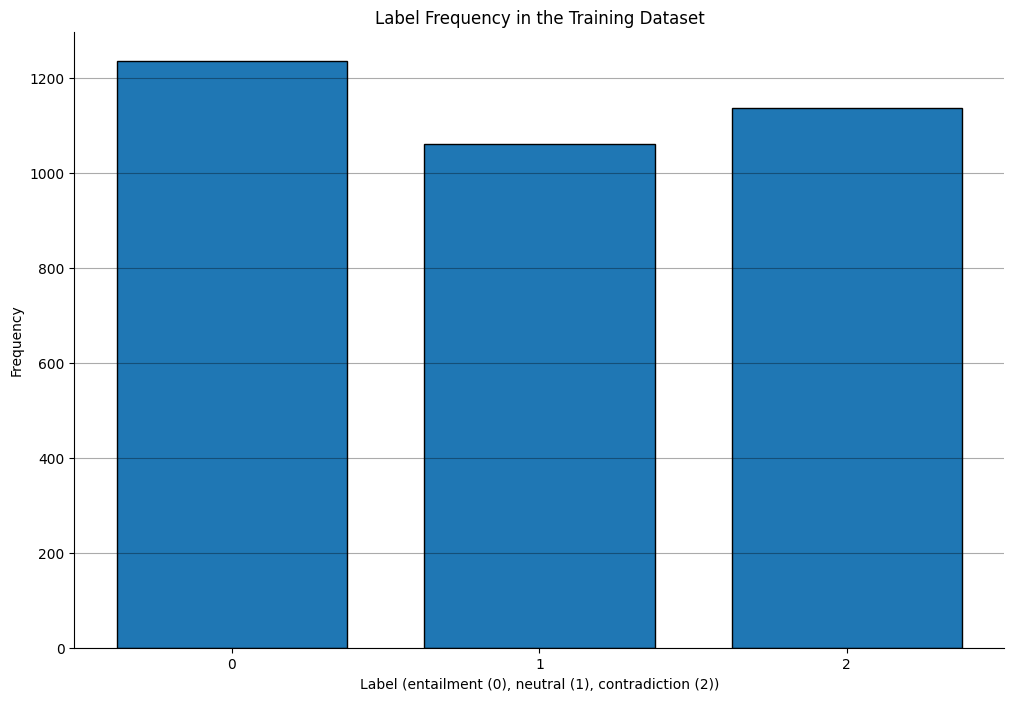

In [16]:
labels = electra_en_dataset.label.to_numpy()

plt.figure(figsize=(12, 8))

plt.hist(labels, bins=range(4), align="left", rwidth=0.75, edgecolor="black")

plt.xticks(numpy.arange(3))

for pos in ["top", "right"]:
    plt.gca().spines[pos].set_visible(False)

plt.grid(axis="y", alpha=0.33, color="black")

plt.xlabel("Label (entailment (0), neutral (1), contradiction (2))")

plt.ylabel("Frequency")

plt.title("Label Frequency in the Training Dataset")

plt.show()

- From the historgram above, it seams that the most frequent premise is an entailment, while a neutral conclusion happens the least.

In [17]:
def get_length_of_text(_text):
    return len(_text)


length_of_hypothesis_texts = electra_en_dataset.hypothesis.apply(get_length_of_text)

length_of_premise_texts = electra_en_dataset.premise.apply(get_length_of_text)

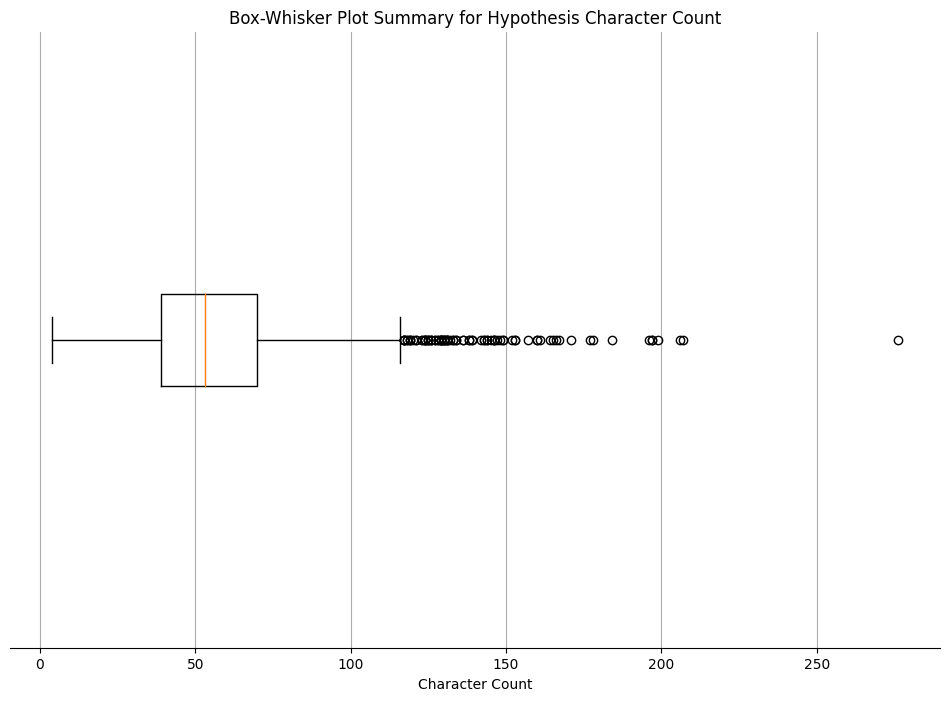

In [18]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_hypothesis_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Hypothesis Character Count")

plt.show()

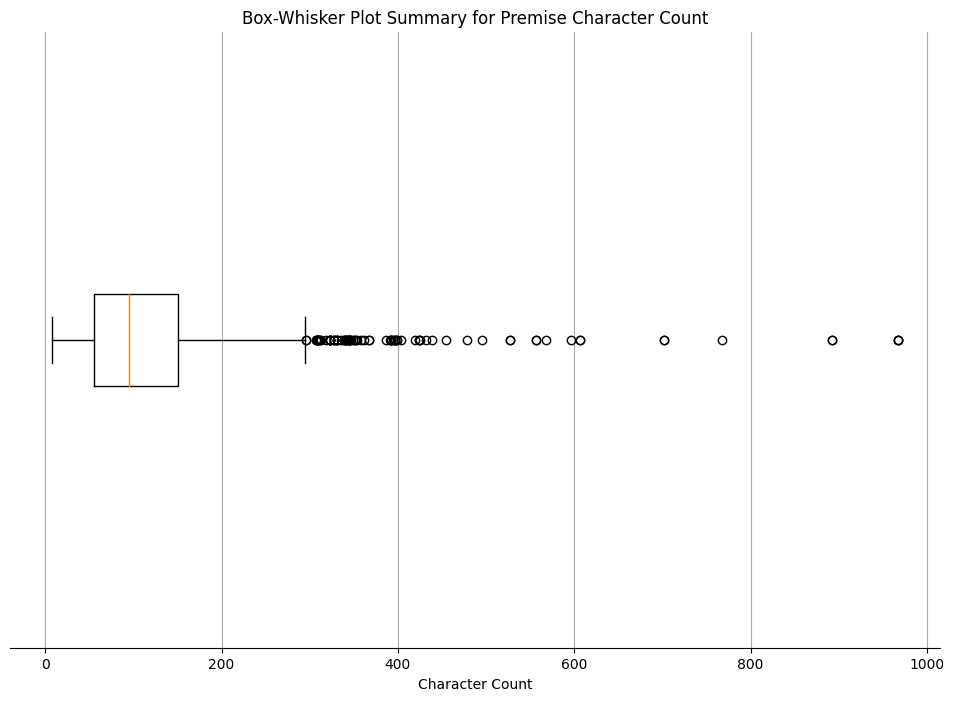

In [19]:
plt.figure(figsize=(12, 8))

plt.boxplot(length_of_premise_texts, vert=False)

for pos in ["top", "right", "left"]:
    plt.gca().spines[pos].set_visible(False)

plt.gca().get_yaxis().set_visible(False)

plt.grid(axis="x", alpha=0.33, color="black")

plt.xlabel("Character Count")

plt.title("Box-Whisker Plot Summary for Premise Character Count")

plt.show()

- From the summary plots of the character counts in the texts, it can be seen that there appear to be many outliers in the distribution. This means that there exists several text elements that are much longer than upper limits of the distribution. This may affect the encoding of the textual embeddings in the model.

- Otherwise, it would seem on average that the premises are longer than the hypotheses.

#### Model Definition

In [25]:
def split_labels(x, y):
    return (x[0], x[1]), y

In [26]:
batch_size = 32

VALIDATION_SPLIT = 0.2
TRAIN_SIZE = int(electra_en_dataset.shape[0] * (1-VALIDATION_SPLIT))

training_dataset = (
    tensorflow.data.Dataset.from_tensor_slices(
        (
            electra_en_dataset[["hypothesis", "premise"]].values,
            electra_en_dataset["label"].values
        )
    )
)

train_dataset = training_dataset.take(TRAIN_SIZE)
val_dataset = training_dataset.skip(TRAIN_SIZE)

train_preprocessed = train_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)
val_preprocessed = val_dataset.map(split_labels, tensorflow.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache().prefetch(tensorflow.data.AUTOTUNE)

In [ ]:
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_discriminator_uncased_en")
bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=512)


def get_max_token_length(dataset, preprocessor):
  token_lengths = []

  for hypothesis, premise in dataset[["hypothesis", "premise"]].values:

    encoded = preprocessor([hypothesis, premise])
    encoded_np = encoded["padding_mask" ]. numpy()
    non_padding_count = encoded_np.sum()
    token_lengths.append(non_padding_count)

  return max(token_lengths)

max_token_length = get_max_token_length(electra_en_dataset, bert_preprocessor)

print(f"Maximum token length in the dataset: {max_token_length}")

In [24]:
electra_discriminator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_discriminator_uncased_en")
# electra_ganerator_token = keras_nlp.models.Tokenizer.from_preset("electra_small_generator_uncased_en")

bert_preprocessor = keras_nlp.models.BertTextClassifierPreprocessor(electra_discriminator_token, sequence_length=512)

train_set = (
    train_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

val_set = (
    val_preprocessed.map(bert_preprocessor, tensorflow.data.AUTOTUNE).cache().prefetch(tensorflow.data.AUTOTUNE)
)

electra_discriminator_back = keras_nlp.models.Backbone.from_preset("electra_small_discriminator_uncased_en")
# electra_generator_back = keras_nlp.models.Backbone.from_preset("electra_small_generator_uncased_en")

bert_classifier = keras_nlp.models.BertClassifier(electra_discriminator_back, 3, preprocessor=None)
bert_classifier.fit(train_set, epochs=3, validation_data=val_set)

Epoch 1/3
85/85 ━━━━━━━━━━━━━━━━━━━━ 155s 375ms/step - loss: 1.0879 - sparse_categorical_accuracy: 0.3712 - val_loss: 0.9979 - val_sparse_categorical_accuracy: 0.4955
Epoch 2/3
85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 528ms/step - loss: 0.9525 - sparse_categorical_accuracy: 0.5665 - val_loss: 0.9071 - val_sparse_categorical_accuracy: 0.5982
Epoch 3/3
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - loss: 0.7336 - sparse_categorical_accuracy: 0.7017 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.6310
